<font size ="8"> <div align="center">**Unemployment Rate Prediction using Hidden Markov Models**</div></font>
<font size ="5"> <div align="center">By **Jon Nyner Gavan**</div></font>

--------------------
# **Context of the Case Study (Unemployment Prediction using Network Analysis)**
--------------------
### **On Hidden Markov Models**

<p align = "justify">
<b>The Hidden Markov Model (HMM) is a probabilistic model that is used to explain or derive the probability of any random process.</b> It basically states that an observed event will be related to a set of probability distributions rather than its step-by-step status. Assume the system being modelled is a Markov chain, with some hidden states in the process. In that case, hidden states are a process that is dependent on the main Markov process/chain.
<p align = "justify">
The primary goal of the HMM is to discover information about a Markov chain by observing its hidden states. Considering a Markov process X with hidden states Y, the HMM establishes that the probability distribution of Y for each time stamp must not be dependent on the history of X at that time.


### **Case Study Descriptions**
<p align = "justify">
The CES program is a monthly survey conducted by the Bureau of Labor Statistics. The program provides employment, hours, and earnings estimates based on payroll records of business establishments. Data produced from the CES survey include nonfarm employment series for all employees, production and nonsupervisory employees, and women employees, as well as average hourly earnings, average weekly hours, monthly umemployment rate and average weekly overtime hours (in manufacturing industries) for both all employees and production and nonsupervisory employees. Labor Force Data comes from the 'Current Population Survey (Household Survey)'.

**The Unemployment Rate represents the number of unemployed as a percentage of the labor force.**

**This rate is also defined as the U-3 measure of labor underutilization.**

-------------------------
## **Dataset Description:**
-------------------------
We will use **Unemployment Rate data from the U.S. Bureau of Labor Statistics** (monthly data from 1948 to 2022).

-------------------------
## **Objectives of the Study:**
-------------------------
In this notebook, the **Hidden Markov Models (HMM) will be displayed to predict the Unemployment Rate over the years.** Using a HMM, we will predict whether the unemployment rate will rise or fall each year based on the data.

When we examine the relationship between the provided data and the unemployment rate, we discover that the unemployment rate peaks whenever there is a recession/pandemic. So we are interested in how we can build Hidden Markov Models (HMM) by using the data we have to identify this. Furthermore, we want to see if our model can predict the unemployment rate more accurately.

### **Importing the necessary libraries**



**Installing the hmmlearn and stats**



In [ ]:
# Installing the necessary libraries
!pip install stats
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 26.1 MB/s 
  Created wheel for stats: filename=stats-0.1.2a0-py3-none-any.whl size=24299 sha256=e4846554325030beb1b514d64183a9e7edb71208f4a982dc2bfdb6d3bc994f46
  Stored in directory: /root/.cache/pip/wheels/e3/1c/58/620049eecc13fb5b4920470895e07a39f86e889a0a58b11976
Successfully built stats
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 129 kB 27.3 MB/s 


**Importing libraries and packages**

In [ ]:
# Library which provides basic statistics functions
import stats

# Libraries for Data manipulation and processing
import pandas as pd
import numpy as np
import math

# Auxiliary
import datetime
from copy import deepcopy
from tqdm import tqdm

# Library for plots and visualisations
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
import seaborn as sns
sns.set()


# Machine Learning Libraries
from sklearn.linear_model import LinearRegression
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

**Loading the data and Taking a quick look**

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Loading the data
dataset=pd.read_csv('UNEMPRATE.csv')

In [ ]:
# Looking at the last rows of the data
dataset.tail()

,DATE,UNRATE
886,2021-11-01,4.2
887,2021-12-01,3.9
888,2022-01-01,4.0
889,2022-02-01,3.8
890,2022-03-01,3.6


In [ ]:
# Looking at datatypes
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    891 non-null    object 
 1   UNRATE  891 non-null    float64
dtypes: float64(1), object(1)
memory usage: 14.0+ KB


### **Exploratory Analysis  - Employment stability over the years**

In [ ]:
# Extracting Datetime components
dataset['Month']=pd.DatetimeIndex(dataset['DATE']).month
dataset['Year']=pd.DatetimeIndex(dataset['DATE']).year

In [ ]:
# Getting avearge values
ma_5_yr=dataset['UNRATE'].rolling(60).mean()
ma_3_yr=dataset['UNRATE'].rolling(36).mean()

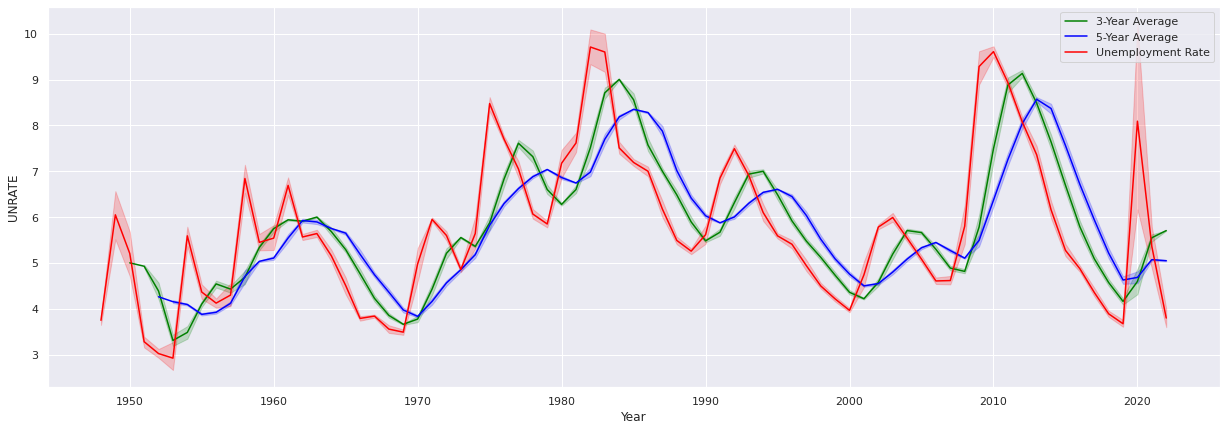

In [ ]:
# Generating time series
plt.figure(figsize=(21,7))
sns.lineplot(dataset['Year'],ma_3_yr,color='green',label="3-Year Average")
sns.lineplot(dataset['Year'],ma_5_yr,color='blue',label="5-Year Average")
sns.lineplot(dataset['Year'],dataset['UNRATE'],color='red',label="Unemployment Rate")

* **We observe periods of positive and negative growth. Possibly, there is a hidden process that is influencing the trends.**

* The portion of the phenomenon that cannot be observed is represented by a hidden process and it is modeled using a Markov process model.
* We can see the 5-year average is far from the actual trend. The 3-year average looks closer. Let's find out the most stable years.

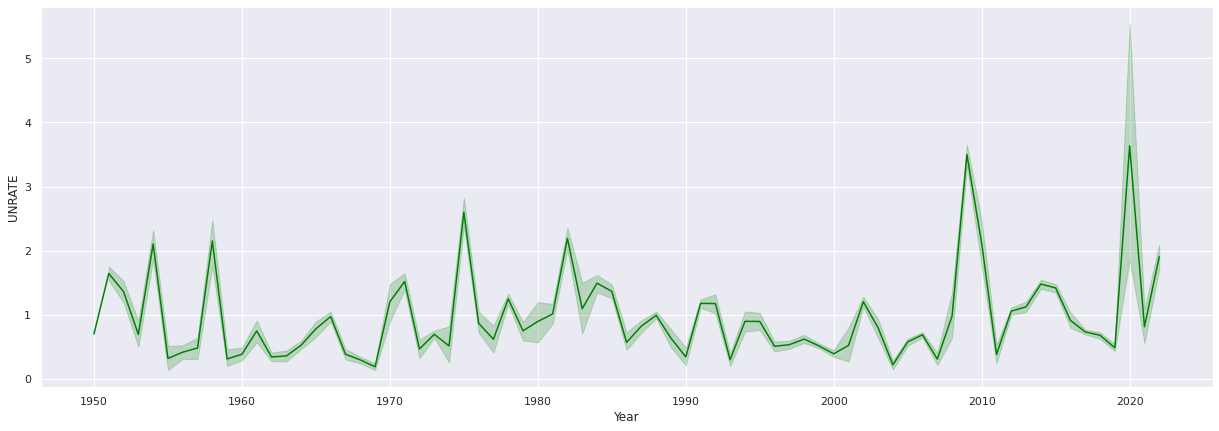

In [ ]:
# Plotting time series for 3 years
plt.figure(figsize=(21,7))
sns.lineplot(dataset['Year'],np.abs(ma_3_yr-dataset['UNRATE']),color='green')

> **Most Stable Year**

In [ ]:
# Printing out the year with least unemployment rate
dataset['DATE'][(np.abs(ma_3_yr-dataset['UNRATE'])).argmin()]

'2001-02-01'

In [ ]:
# transforming to datetime
from datetime import datetime
dataset['DATE']=pd.to_datetime(dataset['DATE'])

> **Checking Year-wise Unemployment Rate**

In [ ]:
# Lookingn at unemployment rate Median across years
dataset.groupby(['Year'])['UNRATE'].median()

Year
1948    3.80
1949    6.30
1950    5.20
1951    3.25
1952    3.00
        ... 
2018    3.85
2019    3.60
2020    7.40
2021    5.60
2022    3.80
Name: UNRATE, Length: 75, dtype: float64

<Figure size 1440x720 with 0 Axes>

> **Fluctuation in monthly unemployment for each year**

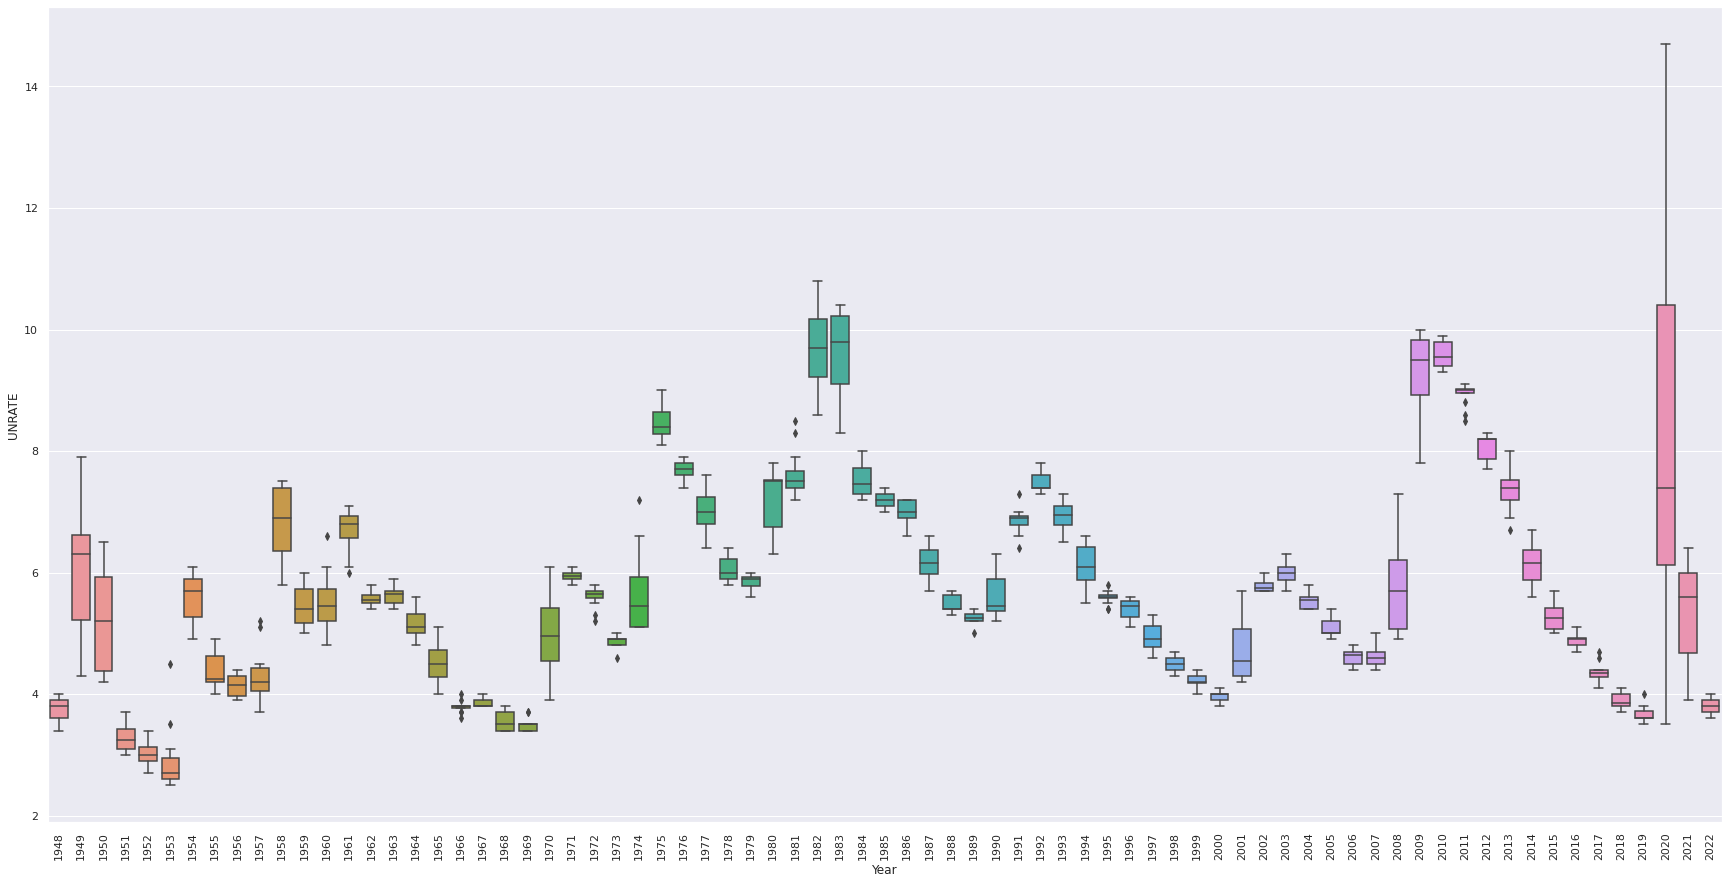

In [ ]:
# Plotting boxplots for unemployment rate across years
plt.figure(figsize=(30,15))
sns.boxplot(dataset['Year'],dataset['UNRATE'])
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Looking at standard deviations onf UNRATEacross the years
dataset.groupby(['Year'])['UNRATE'].std().reset_index().dropna().sort_values(['UNRATE'],ascending=False)[:10].reset_index(drop=True)

,Year,UNRATE
0,2020,3.616743
1,1949,1.031768
2,1950,0.894893
3,2021,0.831711
4,2008,0.780443
5,1983,0.761577
6,1982,0.719164
7,2009,0.696528
8,1974,0.674818
9,1970,0.664466


* **The years with the highest unemployment rate correspond to recession/COVID periods. This is to be expected, as unemployment spikes during times of economic distress.** COVID-19 had a dramatic effect on the labor market.
* Unlike a strike or weather event, the effect was nationwide in the US and, for some industries, sustained over a long period.
* The Recession of 1949 was also a downturn in the United States lasting for 11 months. Hence, 2020 has the highest unemployment rate followed by 1949.

> **Fluctuation in employment for a particular month**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

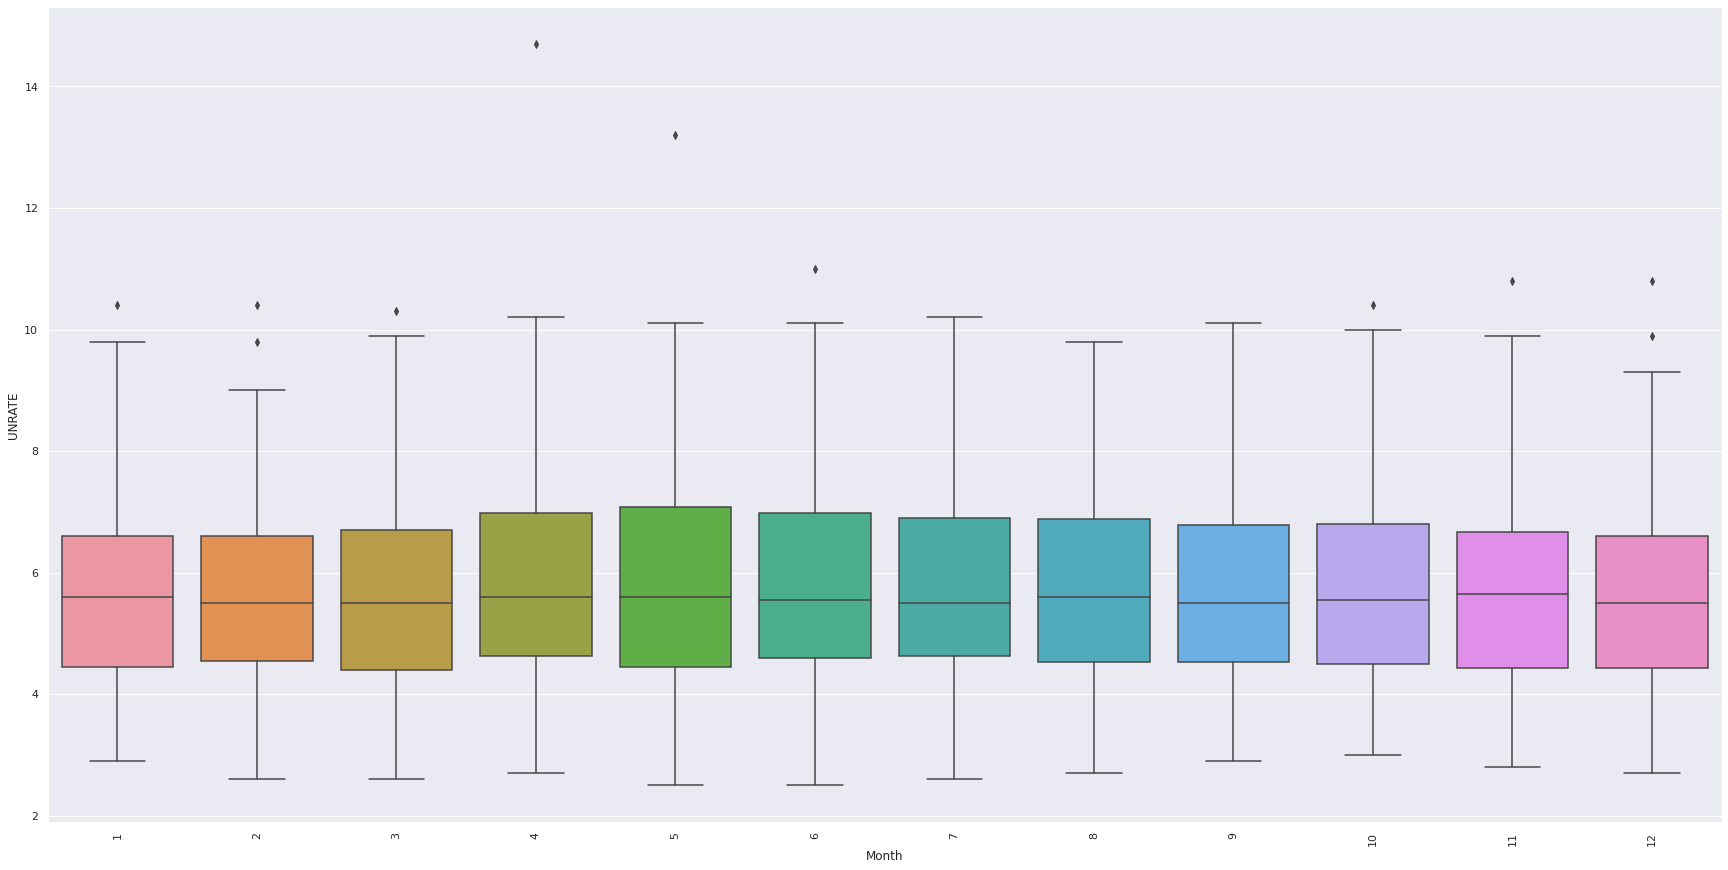

In [ ]:
# Looking at unemployment rates across months
plt.figure(figsize=(30,15))
sns.boxplot(dataset['Month'],dataset['UNRATE'])
plt.xticks(rotation=90)

* **No fluctuation reflects that the month has limited role in determining unemeployment**.

* Since each month is present in every year, the distribution is similar at month level.


> **Checking for seasonality in the data**




* Seasonality is a characteristic of a time series in which the data experiences regular and predictable changes that recur every calendar year. Any predictable fluctuation or pattern that recurs or repeats over a one-year period is said to be seasonal.

In [ ]:
# Adding Seasonality and noise column
dataset['SEASONALITY AND NOISE'] = dataset['UNRATE']/ma_5_yr

In [ ]:
# first add a month column
# dataset['Month'] = dataset.index.strftime('%m').astype(np.int)

# initialize the month based dictionaries to store the running total of the month wise  seasonal sums and counts
average_seasonal_values = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}
average_seasonal_value_counts = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}

#calculate the sums and counts
for i in range(0, dataset['SEASONALITY AND NOISE'].size):
    if math.isnan(dataset['SEASONALITY AND NOISE'][i]) is False:
        average_seasonal_values[dataset['Month'][i]] = average_seasonal_values[dataset['Month'][i]] +dataset['SEASONALITY AND NOISE'][i]
        average_seasonal_value_counts[dataset['Month'][i]] = average_seasonal_value_counts[dataset['Month'][i]] + 1

#create a new column in the data frame and fill it with the value of the average seasonal component for the corresponding month
for i in range(1, 13):
    average_seasonal_values[i] = average_seasonal_values[i] / average_seasonal_value_counts[i]



dataset['SEASONALITY'] = np.nan

for i in range(0, dataset['SEASONALITY AND NOISE'].size):
    if math.isnan(dataset['SEASONALITY AND NOISE'][i]) is False:
        dataset['SEASONALITY'][i] = average_seasonal_values[dataset['Month'][i]]

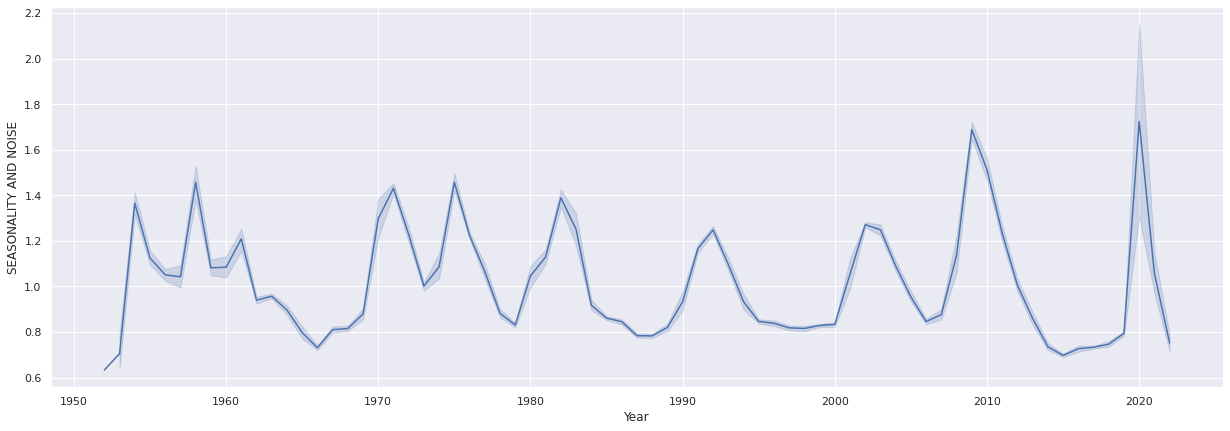

In [ ]:
plt.figure(figsize=(21,7))
sns.lineplot(dataset['Year'],dataset['SEASONALITY AND NOISE'])

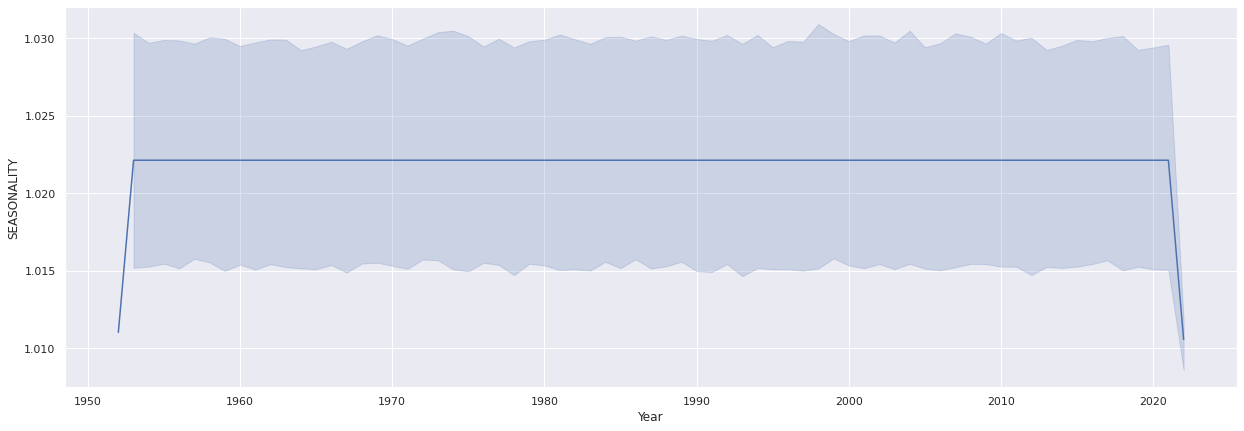

In [ ]:
plt.figure(figsize=(21,7))
sns.lineplot(dataset['Year'],dataset['SEASONALITY'])
plt.show()

* **No seasonality observed in the data for the 5 yr moving average**

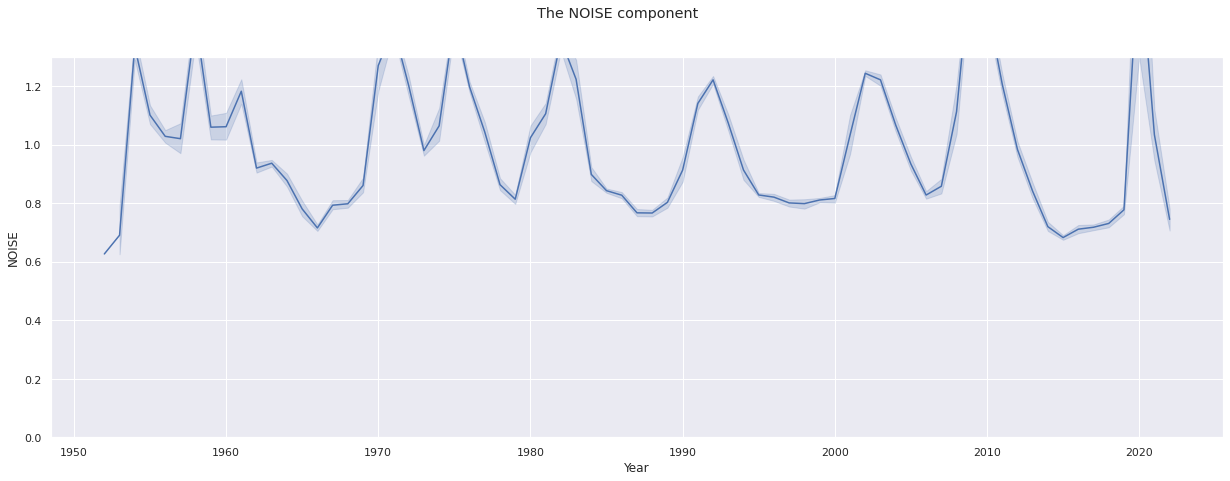

In [ ]:
dataset['NOISE'] = dataset['SEASONALITY AND NOISE']/dataset['SEASONALITY']

#plot the seasonal component
fig = plt.figure(figsize=(21,7))
fig.suptitle('The NOISE component')
plt.ylim(0, 1.3)
sns.lineplot(dataset['Year'],dataset['NOISE'])
plt.show()

* Most of the fluctuation is reflecting as noise. No seasonality and trend in data suggests we cannot decompose this time series into trend and sesonality components.

* The unemeployment rate, as suspected, seems to be determined more by underlying economic states like recession, COVID, budget, and investments in the market. HMMs can be used to identify such hidden states that can help us in predicting these patterns better.

### **Hidden Markov Model Training**



* A HMM can be used to study a phenomena in which some portion of phenomena is directly observed while rest of it can't be observed. The effect of the unobserved portion can only be estimated and not exactly computed.

* We represent such phenomena using a mixture of two random processes.

* One of the two processes is a ‘**visible process**’. It is used to represent the observable portion of the phenomenon. The visible process is modeled using a suitable regression model such as ARIMA, the Integer Poisson model, or the ever popular Linear Model.

* The portion that cannot be observed is represented by a ‘**hidden process**’ which is modeled using a Markov process model.

**Reference:** https://towardsdatascience.com/a-math-lovers-guide-to-hidden-markov-models-ad718df9fde8

In [ ]:
# Setting the values
values = dataset['UNRATE'][:-24].values.reshape(-1,1)

In [ ]:
# Dividing the dataset into training and testing data
N =650
train = values[:N]
test = values[N:]

> **Hyperparameter Tuning**



  * There are two main parameters in HMMs:
  *  n_components ----> Determines the number of hidden states to be used in the model
  *  Algorithm ----> The Viterbi Algorithm






* **The Viterbi algorithm** is a dynamic programming algorithm for obtaining the maximum a-posteriori probability estimate of the most likely sequence of hidden states, called the Viterbi path, that results in a sequence of observed events, especially in the context of Markov information sources and Hidden Markov Models (HMM).

In [ ]:
# Setting the hyperparameters to be looked into
hyperparameter_grid = {
    'n_components': [2,5,7,10,12,15,17,20,22,25,27,30,32,35,37,40],
    'covariance_type' :'diag',
    'algorithm' : ['algo','verterbi'],
    'n_iter' :10000
}

In [ ]:
# Create and store all models combinations of n_components and algo
n_comp=[]
mse=[]
mae=[]
al=[]

for i in range(2,50,2):
  for algo in ['map','viterbi']:
    model_hmm = GaussianHMM(n_components=i+2, covariance_type="diag", algorithm =algo, n_iter=10000, random_state = 42)
    model_hmm.fit(train)
    prediction_hmm = model_hmm.predict(test)
    n_comp.append(i+2)
    al.append(algo)
    mse.append(mean_squared_error(test, prediction_hmm) ** (1 / 2))
    mae.append(mean_absolute_error(test, prediction_hmm))

Fitting a model with 727 free scalar parameters with only 650 data points will result in a degenerate solution.
Fitting a model with 727 free scalar parameters with only 650 data points will result in a degenerate solution.
Fitting a model with 839 free scalar parameters with only 650 data points will result in a degenerate solution.
Fitting a model with 839 free scalar parameters with only 650 data points will result in a degenerate solution.
Fitting a model with 959 free scalar parameters with only 650 data points will result in a degenerate solution.
Fitting a model with 959 free scalar parameters with only 650 data points will result in a degenerate solution.
Fitting a model with 1087 free scalar parameters with only 650 data points will result in a degenerate solution.
Fitting a model with 1087 free scalar parameters with only 650 data points will result in a degenerate solution.
Fitting a model with 1223 free scalar parameters with only 650 data points will result in a degenerate

In [ ]:
# Creating a dataframe of model performance
model_df=pd.DataFrame({'comp':n_comp,'mse':mse,'mae':mae,'al':algo})

In [ ]:
# Displaying the model's performance
model_df[model_df['mae']==model_df['mae'].min()]

,comp,mse,mae,al
6,10,3.373426,2.967742,viterbi


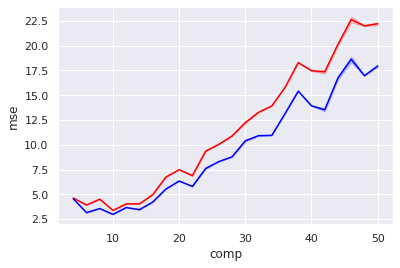

In [ ]:
# looking at model performance with increasing number of model components
sns.lineplot(model_df['comp'],model_df['mse'],color='red')
sns.lineplot(model_df['comp'],model_df['mae'],color='blue')

In [ ]:
# Initializing the GaussianHMM
model_hmm = GaussianHMM(n_components=14, covariance_type="diag", algorithm = 'viterbi', n_iter=10000, random_state = 42)
model_hmm.fit(train)
prediction_hmm = model_hmm.predict(test)

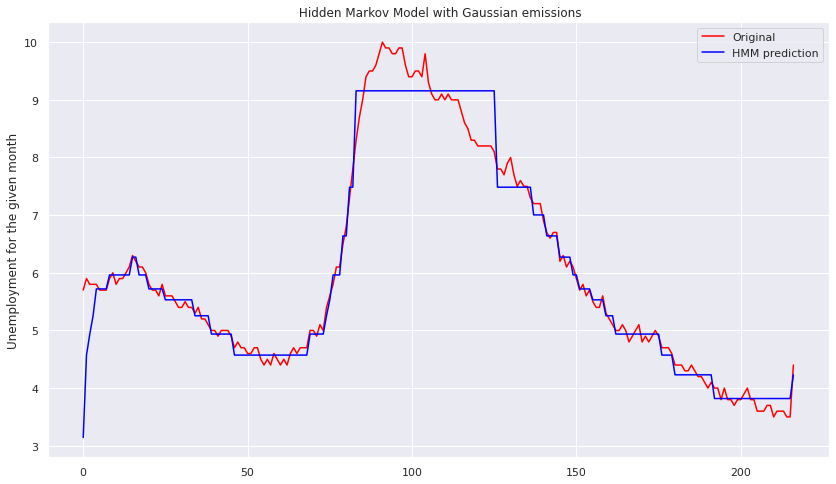

In [ ]:
# Plotting the HMM performance
labels = model_hmm.predict(test)
means = np.zeros_like(test)
for i in range(model_hmm.n_components):
    means[labels == i] = model_hmm.means_[i]

plt.figure(figsize=(14, 8))
plt.title(' Hidden Markov Model with Gaussian emissions')
plt.ylabel('Unemployment for the given month')
plt.plot(test, color = 'red', label = 'Original')
plt.plot(means, color = 'blue', label = 'HMM prediction')
plt.legend()
plt.show()

In [ ]:
# Looking at Model Performance Evaluation in terms RMSE
rmse_hmm = mean_squared_error(test, prediction_hmm) ** (1 / 2)
rmse_hmm

4.038444286859052

In [ ]:
# Looking at Model Performance Evaluation in terms of MAE
mae_hmm = mean_absolute_error(test, prediction_hmm)
mae_hmm

3.4525345622119805

## **Conclusions**


1.  We found the Hidden Markov Model to follow the actual data very closely.
2.  The peaks seem to be modelled less accurately in comparison to the original data.

